In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

Key parameters:

In [42]:
learning_rate = 1e-4  # learning rate
window_size = 3       # window size
pred_size = 1         # prediction step
num_features = 4      # number of features per vector


In [43]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  """
    Convert time series data into a supervised learning format.

    :param data: Time series data (list or numpy array).
    :param n_in: Number of lag observations as input (default is 1).
    :param n_out: Number of future observations as output (default is 1).
    :param dropnan: Whether to drop rows with NaN values (default is True).
    :return: DataFrame with lagged and forecasted observations.
    """
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # Input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # Forecast sequence (t, t+1, ... t+n_out)
  for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
          names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # Drop rows with NaN values
  if dropnan:
      agg.dropna(inplace=True)
  return agg

**Model**

In [44]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.network(x)


In [45]:
# Evaluate the model
def get_predictions_and_targets(loader, model):
  """
    Get predictions and corresponding targets from a PyTorch model using a data loader.

    :param loader: Data loader providing batches of input data and labels.
    :param model: Trained PyTorch model.
    :return: Numpy arrays containing predictions and corresponding targets.
    """
  model.eval()
  predictions, targets = [], []
  with torch.no_grad():
      for inputs, labels in loader:
          outputs = model(inputs)
          predictions.append(outputs.numpy())
          targets.append(labels.numpy())
  predictions = np.vstack(predictions)
  targets = np.vstack(targets)
  return predictions, targets

In [46]:
def evaluate_model(model, test_X, test_y, train_loader, test_loader, criterion):
    model.eval()
    with torch.no_grad():
        predictions = model(test_X)
        test_loss = criterion(predictions, test_y)
    print(f'Test Loss: {test_loss.item()}')

    train_predictions, train_targets = get_predictions_and_targets(train_loader, model)
    test_predictions, test_targets = get_predictions_and_targets(test_loader, model)

    train_mae = mean_absolute_error(train_targets, train_predictions)
    train_mse = mean_squared_error(train_targets, train_predictions)
    test_mae = mean_absolute_error(test_targets, test_predictions)
    test_mse = mean_squared_error(test_targets, test_predictions)

    print(f"Training MAE: {train_mae}, Training MSE: {train_mse}")
    print(f"Testing MAE: {test_mae}, Testing MSE: {test_mse}")


**Main**

In [47]:
if __name__ == "__main__":
    # Load the dataset
    url = 'https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_ottawa_daily.csv'
    data = pd.read_csv(url)

    data['date'] = pd.to_datetime(data['date'])
    # Interpolate missing solar radiation values
    data['solar_radiation'].interpolate(method='linear', inplace=True)

    # Filter data for dates between May 1st and November 30th for each year
    filtered_data = data[(data['date'].dt.month >= 5) & (data['date'].dt.month <= 11)]
    data_filtered = data[(data['date'].dt.year >= 2015) & (data['date'].dt.year <= 2022)]

    # Select the required columns and preprocess
    columns_required = ['avg_hourly_temperature', 'precipitation', 'avg_hourly_pressure_station', 'solar_radiation']
    data_filtered = data_filtered[columns_required].dropna()

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_filtered)

    # Convert to supervised learning problem with a window size of 3DAYS
    data_supervised = series_to_supervised(data_scaled, window_size, pred_size)  ##7          ####################################

    # Split the dataset
    n_obs = window_size * num_features  # Update for 3DAYS window size// and 4 features     #############################
    values = data_supervised.values
    n_train_days = int(len(values) * 0.8)
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]
    train_X, train_y = train[:, :n_obs], train[:, -num_features:]
    test_X, test_y = test[:, :n_obs], test[:, -num_features:]

    # Convert to tensors
    train_X = torch.tensor(train_X, dtype=torch.float32)
    train_y = torch.tensor(train_y, dtype=torch.float32)
    test_X = torch.tensor(test_X, dtype=torch.float32)
    test_y = torch.tensor(test_y, dtype=torch.float32)

    # DataLoader
    train_dataset = TensorDataset(train_X, train_y)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_dataset = TensorDataset(test_X, test_y)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize the model with the updated input dimension
    #model = MLP(12, 4)
    model = MLP(n_obs, num_features)                                     # Update for 3DAYS window size 12/// 7days 28/// 30DAYS 120
    criterion = nn.MSELoss()                                     ##########################################
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    epochs = 50
    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


    evaluate_model(model, test_X, test_y, train_loader, test_loader, criterion)


<ipython-input-47-584125afa730>:4: DtypeWarning: Columns (46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(url)


Epoch 1/50, Loss: 0.14868299663066864
Epoch 2/50, Loss: 0.0702563151717186
Epoch 3/50, Loss: 0.04022479057312012
Epoch 4/50, Loss: 0.028469853103160858
Epoch 5/50, Loss: 0.01702296920120716
Epoch 6/50, Loss: 0.02506863698363304
Epoch 7/50, Loss: 0.01764030195772648
Epoch 8/50, Loss: 0.01716633513569832
Epoch 9/50, Loss: 0.021523339673876762
Epoch 10/50, Loss: 0.022702928632497787
Epoch 11/50, Loss: 0.0219083521515131
Epoch 12/50, Loss: 0.01701579988002777
Epoch 13/50, Loss: 0.012425832450389862
Epoch 14/50, Loss: 0.011849564500153065
Epoch 15/50, Loss: 0.01761792041361332
Epoch 16/50, Loss: 0.01632838137447834
Epoch 17/50, Loss: 0.015493660233914852
Epoch 18/50, Loss: 0.012749304994940758
Epoch 19/50, Loss: 0.014580720104277134
Epoch 20/50, Loss: 0.014490465633571148
Epoch 21/50, Loss: 0.014310777187347412
Epoch 22/50, Loss: 0.014475363306701183
Epoch 23/50, Loss: 0.012535536661744118
Epoch 24/50, Loss: 0.013352609239518642
Epoch 25/50, Loss: 0.011343011632561684
Epoch 26/50, Loss: 0.0



```
Epoch 50/50, Loss: 0.009859252721071243
Test Loss: 0.01037069596350193
Training MAE: 0.07271228730678558, Training MSE: 0.011210594326257706
Testing MAE: 0.07027967274188995, Testing MSE: 0.01037069596350193
```



**Prediction with recursive forcasting**

In [48]:
def rolling_window_predictions(model, initial_window, scaler, n_predictions):
    """
    Predict future values using a rolling window approach.

    :param model: Trained PyTorch model for making predictions.
    :param initial_window: The last known window of features to start making predictions from.
    :param scaler: Fitted MinMaxScaler instance used for inverse transforming the predictions.
    :param n_predictions: Number of future time steps to predict.
    :return: Array of predictions.
    """
    model.eval()
    current_window = initial_window.clone().detach()  # Ensure it's a tensor.
    all_predictions = []

    with torch.no_grad():  # No gradient calculation for inference.
        for _ in range(n_predictions):
            # Make a prediction using the current window.
            prediction = model(current_window).numpy()  # Model output to numpy array.
            # Inverse scale the prediction to the original scale.
            prediction = scaler.inverse_transform(prediction).flatten()
            # Store the prediction.
            all_predictions.append(prediction)

            # Update the window for the next prediction.
            # Convert the prediction back to a tensor and reshape for concatenation.
            prediction_tensor = torch.tensor(scaler.transform(prediction.reshape(1, -1)), dtype=torch.float32)
            # Roll the window to remove the oldest day and insert the new prediction at the end.
            current_window = torch.roll(current_window, -num_features, dims=1)
            current_window[:, -num_features:] = prediction_tensor[:, :num_features]  # Assuming 4 features per day.

    return np.array(all_predictions)


**Predicting for next two weeks**

In [49]:
data_2023 = data[(data['date'].dt.year == 2023) & (data['date'].dt.month >= 5) & (data['date'].dt.month <= 11)]
# Ensure data is sorted by date
data_2023 = data_2023.sort_values(by='date')
data_2023_filtered = data_2023[columns_required]
# Apply scaling using the already fitted scaler
data_2023_scaled = scaler.transform(data_2023_filtered)


# Extract the first 3 days (rows) as the initial window for the prediction
initial_window = data_2023_scaled[:window_size].reshape(1, -1)                             #set window size
initial_window = torch.tensor(initial_window, dtype=torch.float32)


n_future_steps = 210
# Generate predictions
future_predictions = rolling_window_predictions(model, initial_window, scaler, n_future_steps)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScal

avg_hourly_temperature - MAE: 6.092714536121914, RMSE: 8.72490344530207
precipitation - MAE: 3.751913417293912, RMSE: 6.094234528923266
avg_hourly_pressure_station - MAE: 0.5944107506161647, RMSE: 0.7385578700588392
solar_radiation - MAE: 8064.967127046131, RMSE: 9518.313397329312


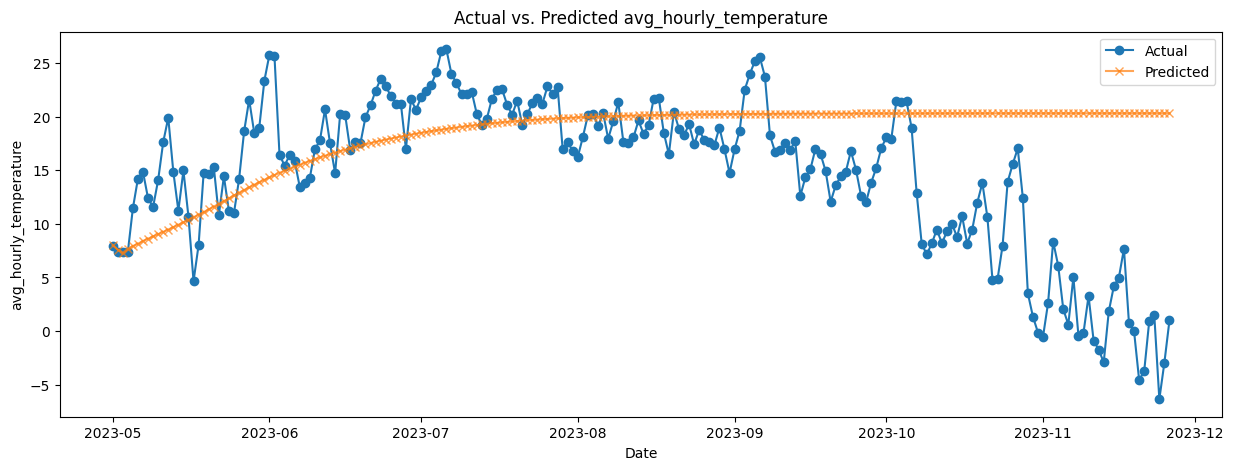

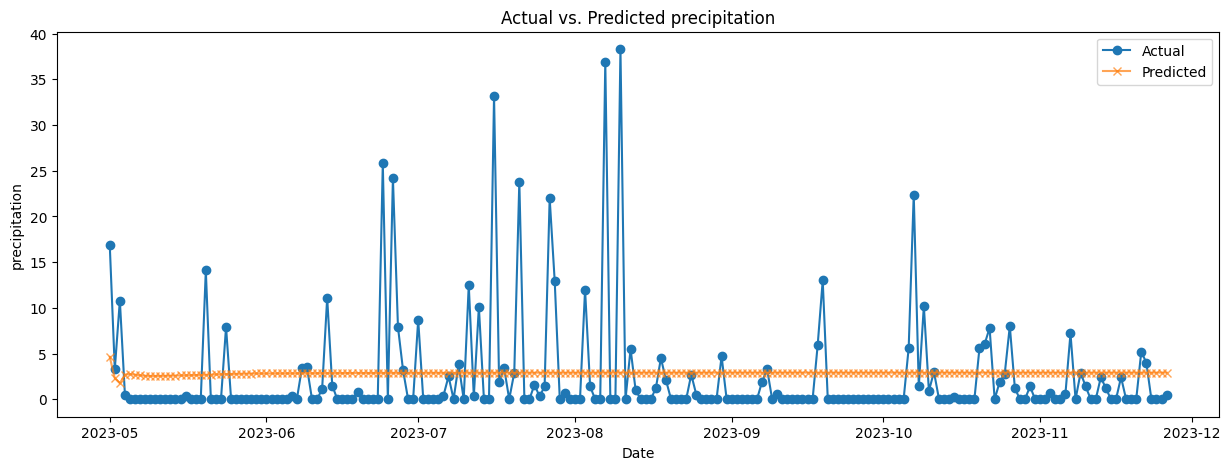

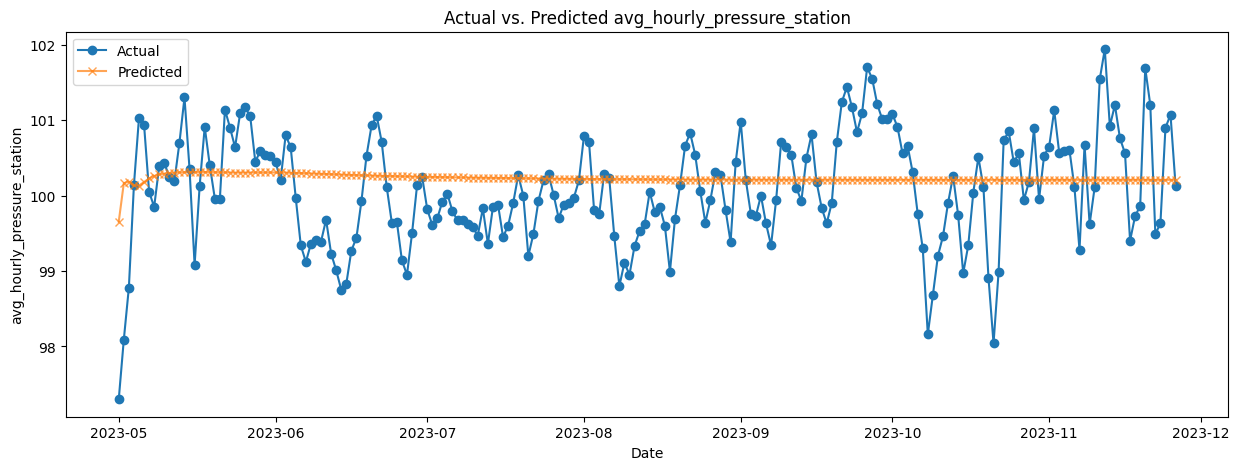

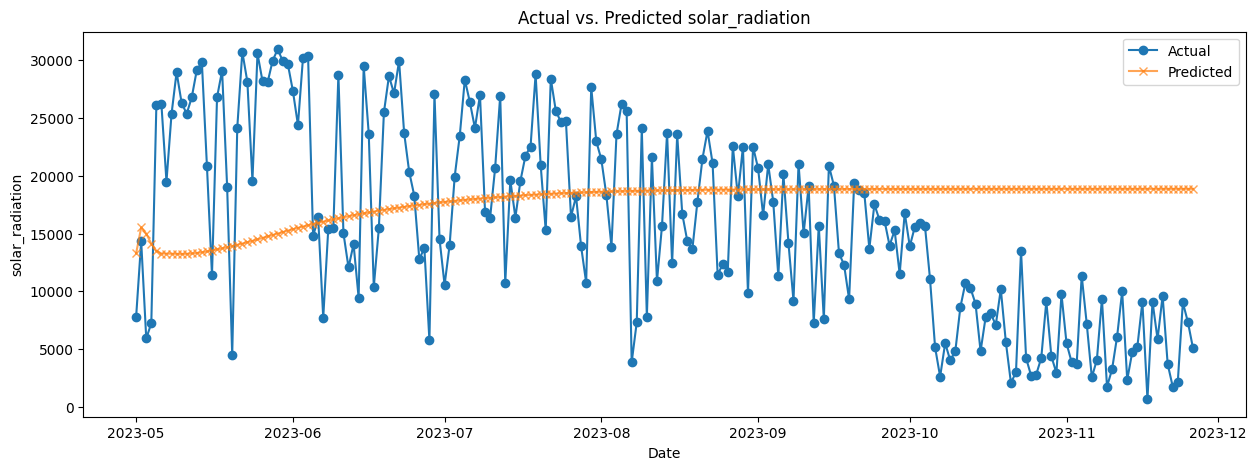

<Figure size 640x480 with 0 Axes>

In [50]:
# Graph drawing
#start_day = 1  # 1 is May 1st
num_days = 210  # Change to see number of days for prediction. Must be <= n_future_steps above

#pd.to_datetime()

actual_2023 = data_2023.set_index('date')['2023-05-01':'2023-11-30']
actual_values = actual_2023[columns_required]
# Generate the dates corresponding to each prediction
#prediction_dates = pd.date_range(start='2023-05-01', periods=n_future_steps)
prediction_dates = pd.date_range(start='2023-05-01', periods=num_days)

# Convert the predictions array into a DataFrame with the prediction dates
predicted_values = pd.DataFrame(future_predictions[:num_days], index=prediction_dates, columns=columns_required)
# Combine actual and predicted values
comparison_df = actual_values.join(predicted_values, rsuffix='_predicted')

# Ensure both DataFrames are aligned by date
comparison_df_aligned = comparison_df.dropna()

# Recalculate MAE and RMSE using the aligned DataFrame
for feature in columns_required:
    actual = comparison_df_aligned[feature]
    predicted = comparison_df_aligned[f'{feature}_predicted']
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f'{feature} - MAE: {mae}, RMSE: {rmse}')


# Visualization using the aligned DataFrame
for feature in columns_required:
    plt.figure(figsize=(15, 5))
    plt.plot(comparison_df_aligned.index, comparison_df_aligned[feature], label='Actual', marker='o')
    plt.plot(comparison_df_aligned.index, comparison_df_aligned[f'{feature}_predicted'], label='Predicted', marker='x', alpha=0.7)
    plt.title(f'Actual vs. Predicted {feature}')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.legend()
    plt.show()

plt.tight_layout()